In [34]:
import numpy as np
import numpy.linalg as lin
from matplotlib import pyplot as plt
import pandas as pd
from scipy import sparse
import seaborn as sns

import matrix_functions as mf

In [35]:
dim = 100
rng = np.random.default_rng(42)
lambda_min = 1
kappa = 1_000
lambda_max = kappa * lambda_min

a_diag = np.linspace(lambda_min, lambda_max, dim)
A = sparse.diags((a_diag), (0))

In [36]:
denom_deg = 2
def f(x):
    return x**(-denom_deg)

In [4]:
x = rng.standard_normal(dim)
ground_truth = mf.diagonal_fa(f, a_diag, x)
krylov_basis, _ = mf.lanczos(A, x, reorthogonalize=True)

In [33]:
ks = list(range(1, dim+1, 10))
lanczos_errors = []
krylov_errors = []
cheb_interpolant_errors = []
cheb_regression_errors = []

spectrum_discritization = mf.cheb_nodes(200, a=lambda_min, b=lambda_max)
f_spectrum_discritization = f(spectrum_discritization)
CV = mf.cheb_vandermonde(spectrum_discritization, dim+1)

for k, lanczos_estimate in zip(ks, mf.lanczos_fa_multi_k(f, A, x, ks=ks, reorthogonalize=True)):
    lanczos_errors.append(lin.norm(lanczos_estimate - ground_truth))

    krylov_coeffs, _, _, _ = lin.lstsq(krylov_basis[:, :k], ground_truth, rcond=None)
    krylov_error = lin.norm(krylov_basis[:, :k] @ krylov_coeffs - ground_truth)
    krylov_errors.append(krylov_error)

    ## WAIT! should this be k-1 \/ ?
    cheb_interpolant = mf.cheb_interpolation(k, f, lambda_min, lambda_max)
    cheb_interpolant_error = lin.norm(cheb_interpolant(spectrum_discritization) - f_spectrum_discritization, ord=np.inf)
    cheb_interpolant_errors.append(2 * lin.norm(x) * cheb_interpolant_error)

    cheb_coeffs, _, _, _ = lin.lstsq(CV[:, :k], f_spectrum_discritization, rcond=None)
    cheb_regression_error = lin.norm(CV[:, :k] @ cheb_coeffs - f_spectrum_discritization, ord=np.inf)
    cheb_regression_errors.append(2 * lin.norm(x) * cheb_regression_error)

results = pd.DataFrame({
    "Number of matrix-vector products": ks,
    "Error of Lanczos-FA": lanczos_errors,
    "Error of Krylov subspace": krylov_errors,
    "Our bound": (kappa ** denom_deg) * np.array(krylov_errors),
    "Error of Chebyshev interpolant *2||x||": cheb_interpolant_errors,
    "Error of Chebyshev regression *2||x||": cheb_regression_errors
})

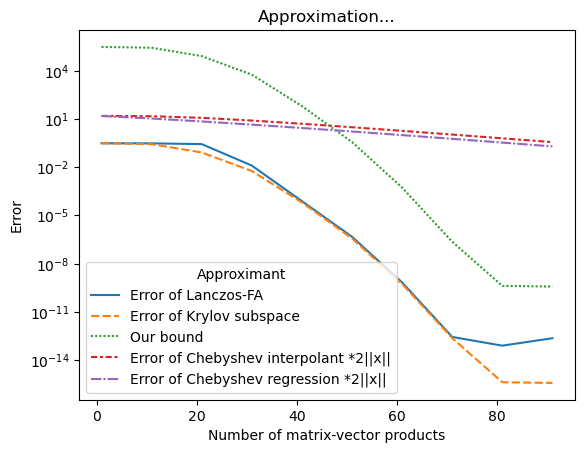

In [6]:
results_long = pd.melt(results, ["Number of matrix-vector products"], value_name="Error", var_name="Approximant")
sns.lineplot(x="Number of matrix-vector products", y="Error", hue="Approximant", style="Approximant", data=results_long).set(
    title='Approximation...',
    yscale='log'
);